In [1]:
from plot_module import save_plot

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn.linear_model import LinearRegression 
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor 

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('Monthly_oil_data.csv', index_col='Production Date', parse_dates=True)

In [3]:
df.head()

,Volume
Production Date,
2015-01-01,67515553.0
2015-02-01,61664960.0
2015-03-01,66342950.0
2015-04-01,67719040.0
2015-05-01,66484591.0


### Logging 

In [4]:
df['LogVolume'] = np.log(df['Volume']) 

In [5]:
df['DiffLogVolume'] = df['LogVolume'].diff()

### Supervised dataset

In [6]:
series = df['DiffLogVolume'].to_numpy()[1:] 

T = 6
X = [] 
Y = [] 

for t in range(len(series) - T): 
    x = series[t:t+T] 
    X.append(x) 
    y = series[t+T] 
    Y.append(y)  

X = np.array(X).reshape(-1, T) 
Y = np.array(Y) 
N = len(X) 
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape (118, 6) Y.shape (118,)


### Train/Test split

In [7]:
Ntest = 12 
train = df.iloc[:-Ntest] 
test = df.iloc[-Ntest:] 

Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest] 
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

### Indexing

In [8]:
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx 

train_idx[:T+1] = False

In [9]:
df['ShiftLogVolume'] = df['LogVolume'].shift(1) 
prev = df['ShiftLogVolume']

In [10]:
last_train = train.iloc[-1]['LogVolume']

### Scaling

In [11]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

Xtrain_scaled = scaler_x.fit_transform(Xtrain)
Xtest_scaled = scaler_x.transform(Xtest)

Ytrain_scaled = scaler_y.fit_transform(Ytrain.reshape(-1, 1)).ravel()

### 1-step and multi-step forecast

In [12]:
def one_step_and_multistep_forecast(model, name):
    print('Model:', name)
    model.fit(Xtrain_scaled, Ytrain_scaled) 

    train_pred_scaled = model.predict(Xtrain_scaled)
    test_pred_scaled = model.predict(Xtest_scaled)

    # store 1-step forecast
    df.loc[train_idx, f'{name}_1step_train'] = prev[train_idx] + scaler_y.inverse_transform(train_pred_scaled.reshape(-1, 1)).ravel()
    df.loc[test_idx, f'{name}_1step_test'] = prev[test_idx] + scaler_y.inverse_transform(test_pred_scaled.reshape(-1, 1)).ravel() 

    # metrics calculations
    mae1 = mean_absolute_error(df.iloc[-Ntest:]['LogVolume'], df.loc[test_idx, f'{name}_1step_test']) 
    print('Test MAE (1-step):', mae1)
    rmse1 = np.sqrt(mean_squared_error(df.iloc[-Ntest:]['LogVolume'], df.loc[test_idx, f'{name}_1step_test']))
    print('Test RMSE (1-step):', rmse1)
    mape1 = mean_absolute_percentage_error(df.iloc[-Ntest:]['LogVolume'], df.loc[test_idx, f'{name}_1step_test'])
    print('Test MAPE(1-step):', mape1)  

    # generate multi-step forecast
    multistep_predictions = [] 

    # first test input
    last_x = Xtest_scaled[0].copy()
    
    while len(multistep_predictions) < Ntest:
        p_scaled = model.predict(last_x.reshape(1, -1))[0] 

        # convert back to original scale
        p = scaler_y.inverse_transform([[p_scaled]])[0, 0]
        multistep_predictions.append(p) 
        
        # shift the window and add the scaled prediction
        last_x = np.roll(last_x, -1)
        last_x[-1] = p_scaled
        

    # store multi-step predictions
    df.loc[test_idx, f'{name}_multistep_test'] = last_train + multistep_predictions

    # metrics calculations
    mae2 = mean_absolute_error(df.iloc[-Ntest:]['LogVolume'], df.loc[test_idx, f'{name}_multistep_test']) 
    print('Test MAE (multi-step):', mae2)
    rmse2 = np.sqrt(mean_squared_error(df.iloc[-Ntest:]['LogVolume'], df.loc[test_idx, f'{name}_multistep_test']))
    print('Test RMSE (multi-step):', rmse2)
    mape2 = mean_absolute_percentage_error(df.iloc[-Ntest:]['LogVolume'], df.loc[test_idx, f'{name}_multistep_test'])
    print('Test MAPE(multi-step):', mape2)

    # plot predictions
    cols = ['LogVolume', f'{name}_1step_train', f'{name}_1step_test', f'{name}_multistep_test']
    df[cols].plot(figsize=(12,6));

Model: LR
Test MAE (1-step): 0.034680970028431325
Test RMSE (1-step): 0.04667794893561829
Test MAPE(1-step): 0.0018734710487864547
Test MAE (multi-step): 0.03814325803880644
Test RMSE (multi-step): 0.05138694347704065
Test MAPE(multi-step): 0.0020611582259448358


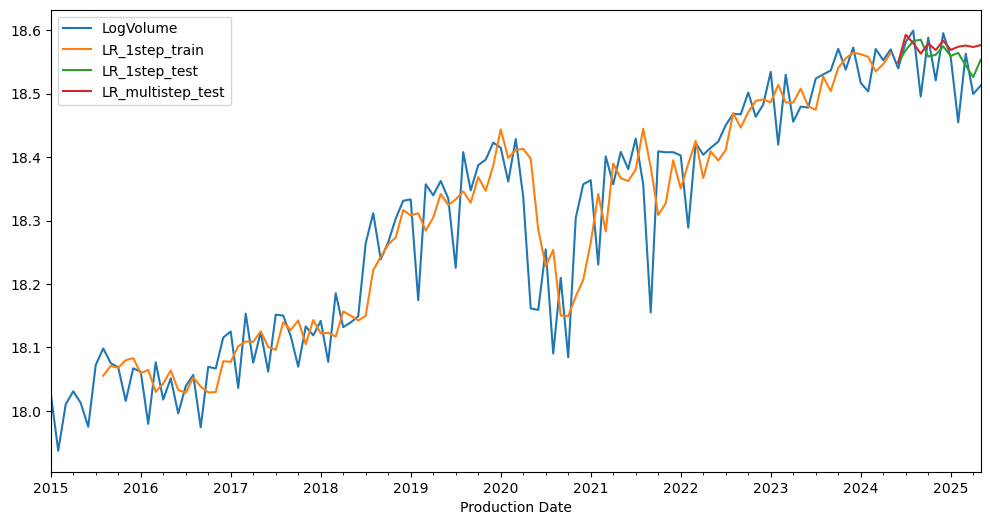

In [13]:
one_step_and_multistep_forecast(LinearRegression(), 'LR')

Model: SVR
Test MAE (1-step): 0.03183024650186065
Test RMSE (1-step): 0.047262095741168575
Test MAPE(1-step): 0.0017200600275033666
Test MAE (multi-step): 0.04345683434814399
Test RMSE (multi-step): 0.05748583451553669
Test MAPE(multi-step): 0.0023475019219362384


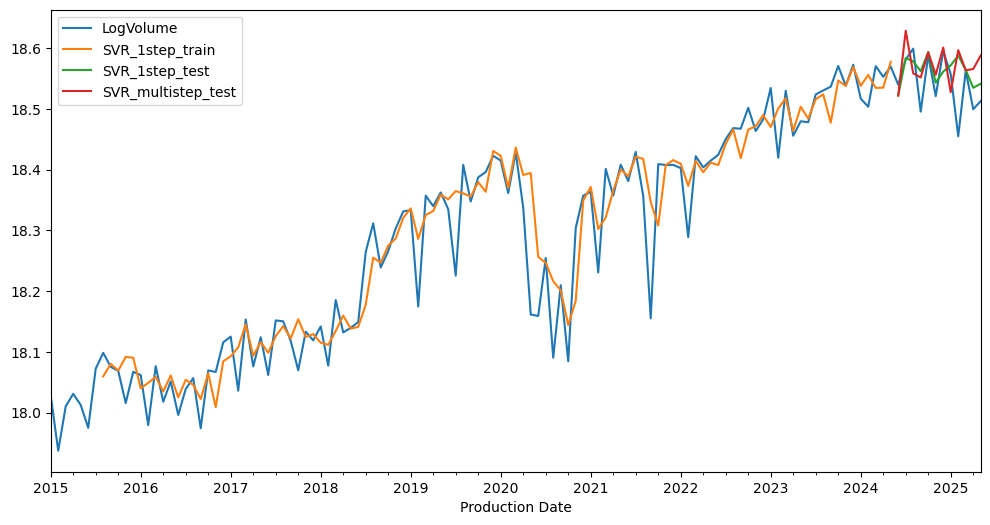

In [14]:
one_step_and_multistep_forecast(SVR(), 'SVR')

Model: RF
Test MAE (1-step): 0.03993524223364927
Test RMSE (1-step): 0.0508308697031174
Test MAPE(1-step): 0.002156087330312009
Test MAE (multi-step): 0.02822742916251819
Test RMSE (multi-step): 0.04027324838475792
Test MAPE(multi-step): 0.0015245494877628486


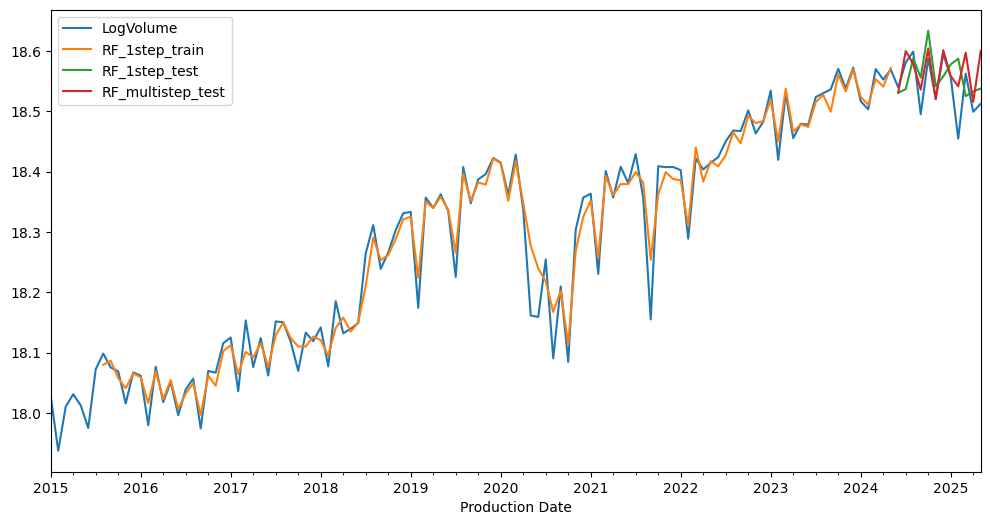

In [15]:
one_step_and_multistep_forecast(RandomForestRegressor(), 'RF')

### Multi-output supervised dataset

In [16]:
Tx = T 
Ty = Ntest 
X = [] 
Y = []  

for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx] 
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y) 

X = np.array(X).reshape(-1, Tx) 
Y = np.array(Y).reshape(-1, Ty) 
N = len(X) 
print('X.shape', X.shape, 'Y.shape', Y.shape)   

X.shape (107, 6) Y.shape (107, 12)


### Train/Test Split

In [17]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1] 
Xtest_m, Ytest_m = X[-1:], Y[-1:]

### Scaling

In [18]:
scaler_xm = StandardScaler() 
scaler_ym = StandardScaler() 

Xtrain_m_scaled = scaler_xm.fit_transform(Xtrain_m)
Xtest_m_scaled = scaler_xm.transform(Xtest_m)

Ytrain_m_scaled = scaler_ym.fit_transform(Ytrain_m)

### Multi-output forecast

In [19]:
def multi_output_forecast(model, name):
    print('Model:', name)
    model.fit(Xtrain_m_scaled, Ytrain_m_scaled) 

    test_pred_scaled = model.predict(Xtest_m_scaled) 

    if test_pred_scaled.ndim == 1:
        test_pred_scaled = test_pred_scaled.reshape(1, -1)

    # save multi-output forecast
    df.loc[test_idx, f'{name}_multioutput_test'] = last_train + scaler_ym.inverse_transform(test_pred_scaled).ravel()
    
    # metrics calculations
    mae3 = mean_absolute_error(df.iloc[-Ntest:]['LogVolume'], df.loc[test_idx, f'{name}_multioutput_test']) 
    print('Test MAE (multi-output):', mae3)
    rmse3 = np.sqrt(mean_squared_error(df.iloc[-Ntest:]['LogVolume'], df.loc[test_idx, f'{name}_multioutput_test']))
    print('Test RMSE (multi-output):', rmse3)
    mape2 = mean_absolute_percentage_error(df.iloc[-Ntest:]['LogVolume'], df.loc[test_idx, f'{name}_multioutput_test'])
    print('Test MAPE(multi-ouput):', mape2) 

    # plot and save plots
    ax = df.plot(y=['LogVolume', f'{name}_1step_train', f'{name}_1step_test',
            f'{name}_multistep_test', f'{name}_multioutput_test'], figsize=(12,6))
    ax.set_title(name)

    fig = ax.get_figure()
    save_plot(fig, f'{name}')

Model: LR
Test MAE (multi-output): 0.03612321031883129
Test RMSE (multi-output): 0.047735577716827834
Test MAPE(multi-ouput): 0.0019517593690700252


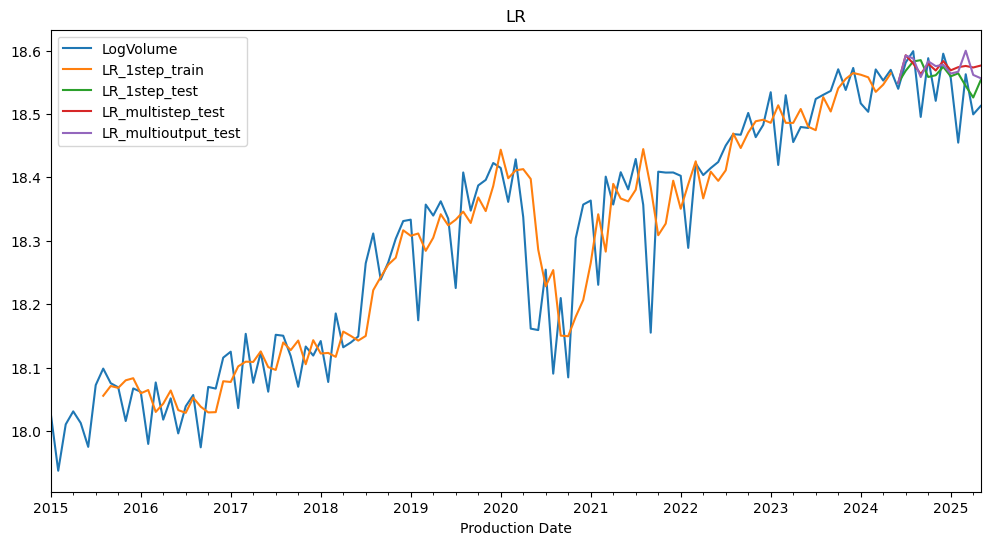

In [20]:
multi_output_forecast(LinearRegression(), 'LR')

Model: RF
Test MAE (multi-output): 0.03289559922731803
Test RMSE (multi-output): 0.0468613848055627
Test MAPE(multi-ouput): 0.0017779648121801347


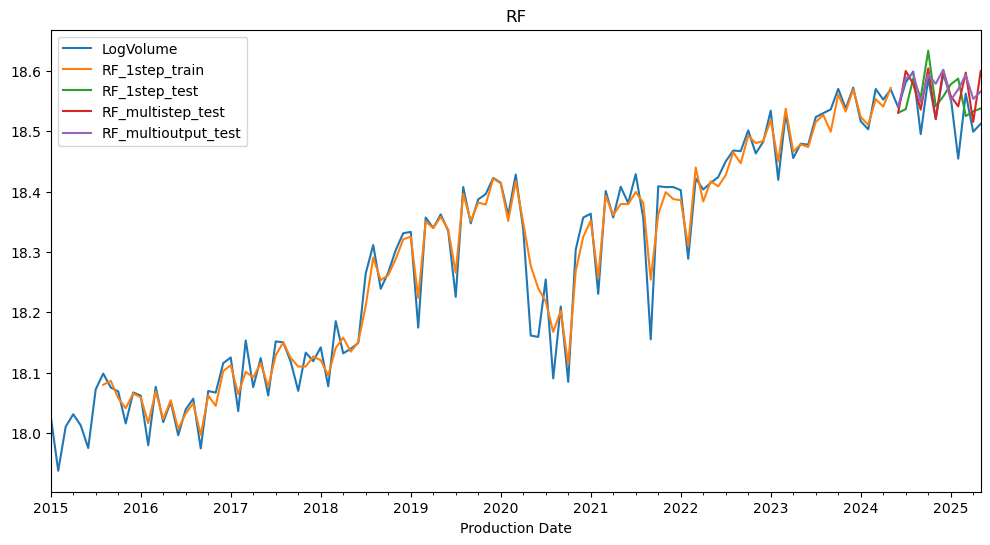

In [21]:
multi_output_forecast(RandomForestRegressor(), 'RF')

In [22]:
class SVRWrapper: 
    def __init__(self, h, **args): 
        self.h = h 
        self.models = [SVR(**args) for _ in range(h)] 

    def fit(self, X, Y): 
        for k in range(self.h): 
            self.models[k].fit(X, Y[:, k]) 

    def predict(self, X):
        P = [m.predict(X) for m in self.models] 
        return np.hstack(P)

Model: SVR
Test MAE (multi-output): 0.04041030329631923
Test RMSE (multi-output): 0.04924737176665624
Test MAPE(multi-ouput): 0.0021823007297748823


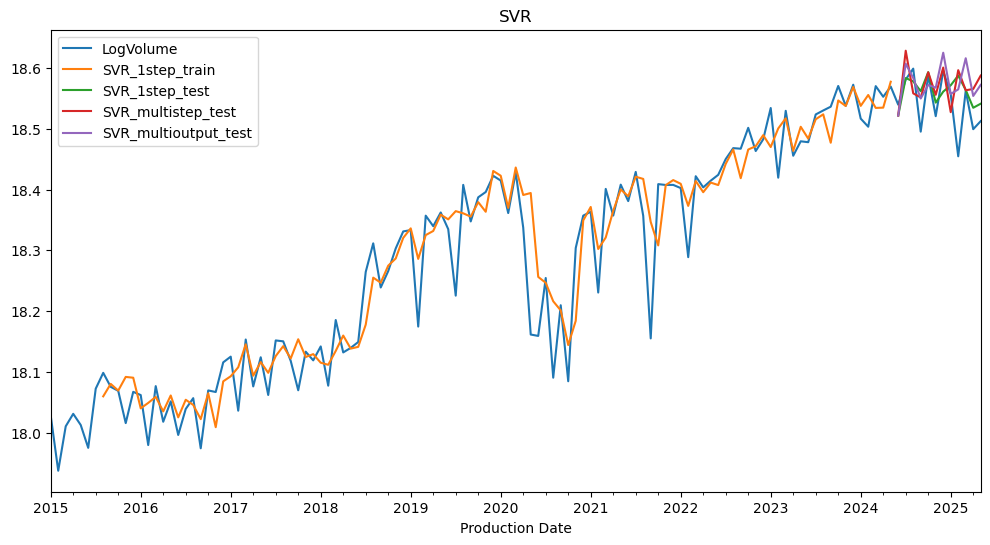

In [23]:
multi_output_forecast(SVRWrapper(Ntest), 'SVR')

### Conclusions

1. One-step predictions achieve good accuracy due to the shorter forecasting horizon. 
2. Random Forest performs best for one-step forecasting, while SVR yields the best results for multi-step predictions.
3. Overall, Linear Regression, SVR, and Random Forest show comparable performance in multi-output forecasting.